In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os

import warnings
warnings.simplefilter('ignore')

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
print(len(os.listdir("/content/drive/MyDrive/Opacity/Train/Normal")))
print(len(os.listdir("/content/drive/MyDrive/Opacity/Train/Opacity")))

936
1310


In [3]:
Train = "/content/drive/MyDrive/Opacity/Train/"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.05,
                                   width_shift_range = 0.2,
                                   height_shift_range= 0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2)

train_gen = train_datagen.flow_from_directory(
    Train,
    target_size=(224, 224),
    batch_size=16,
    subset='training',
    class_mode='binary')

val_gen = train_datagen.flow_from_directory(
    Train, 
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='validation')

Found 2135 images belonging to 2 classes.
Found 111 images belonging to 2 classes.


In [5]:
resnet_layer = tf.keras.applications.ResNet152V2(input_shape=(224,224,3),include_top=False,weights="imagenet",
                                                    pooling='avg')

for layers in resnet_layer.layers:
    layers.trainable=False
    
output_layer = Dense(1,activation='sigmoid')(resnet_layer.output)

resnet_model = Model(resnet_layer.input,output_layer)

234561536/234545216 [==============================] - 6s 0us/step


In [6]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
resnet_history = resnet_model.fit(train_gen,validation_data=val_gen,epochs=15,steps_per_epoch=100,batch_size=16)

Epoch 1/15
100/100 [==============================] - 1450s 14s/step - loss: 0.4762 - accuracy: 0.7756 - val_loss: 0.3891 - val_accuracy: 0.7928
Epoch 2/15
100/100 [==============================] - 384s 4s/step - loss: 0.3273 - accuracy: 0.8662 - val_loss: 0.3087 - val_accuracy: 0.8559
Epoch 3/15
100/100 [==============================] - 160s 2s/step - loss: 0.3089 - accuracy: 0.8693 - val_loss: 0.3012 - val_accuracy: 0.8288
Epoch 4/15
100/100 [==============================] - 82s 820ms/step - loss: 0.2897 - accuracy: 0.8831 - val_loss: 0.3282 - val_accuracy: 0.8288
Epoch 5/15
100/100 [==============================] - 71s 707ms/step - loss: 0.2981 - accuracy: 0.8755 - val_loss: 0.3133 - val_accuracy: 0.8829
Epoch 6/15
100/100 [==============================] - 67s 672ms/step - loss: 0.2832 - accuracy: 0.8850 - val_loss: 0.3459 - val_accuracy: 0.8468
Epoch 7/15
100/100 [==============================] - 67s 673ms/step - loss: 0.2831 - accuracy: 0.8869 - val_loss: 0.3499 - val_accura

In [16]:
resnet_model.save("/content/drive/MyDrive/Opacity/resnet_model.h5")

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import cv2
import os

import tensorflow as tf
import keras

import warnings
warnings.simplefilter('ignore')
from tensorflow.keras.models import load_model,Model

In [10]:
def get_img_array(img_path, size):
    img = plt.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = keras.preprocessing.image.load_img(img_path, target_size=224)
    array = keras.preprocessing.image.img_to_array(img)    
    x = np.expand_dims(array, axis=0)
    return x

In [11]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [12]:
def grad_cam_final(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img =  tf.keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]

    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

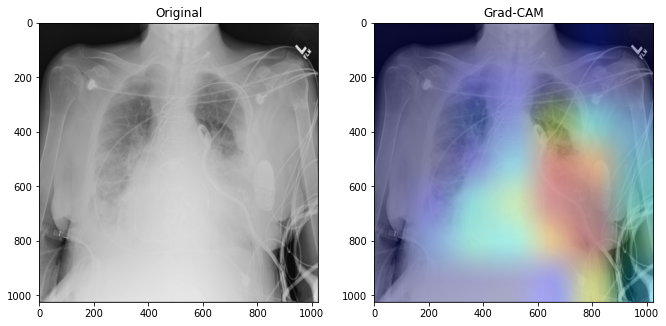

In [15]:
img_path = "/content/drive/MyDrive/Opacity/Train/Opacity/00000116_019.png"
resnet_model.layers[-1].activation = None
img_array = get_img_array(img_path,size=224)
heatmap = make_gradcam_heatmap(img_array, resnet_model, 'conv5_block3_3_conv')
final_img = grad_cam_final(img_path, heatmap)

plt.figure(figsize=(11,9))
plt.subplot(121), plt.imshow(plt.imread(img_path)), plt.title("Original")
plt.subplot(122), plt.imshow(final_img), plt.title("Grad-CAM")
plt.show()